# Clasification Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I {**2110ACDS_T7**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### EDSA-Climate Change Belief Analysis 2022


### Problem Statement

Our clients would like to know people's perception on climate change, whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received, which will increasing their insights and informing future marketing strategies.

SWAT_Team_7 has been consulted to create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

### Process

- 1. analyse the supplied data;
- 2. identify potential errors in the data and clean the existing data set;
- 3. determine if additional features can be added to enrich the data set;
- 4. build a model that is capable of forecasting the three hourly demand shortfalls;
- 5. evaluate the accuracy of the best machine learning model;
- 6. determine if a person believes in climate change or not, and
- 7. explain the inner working of the model to a non-technical audience.
  

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section you are required to import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

In [1]:
import re
import string
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from sklearn.utils import resample

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from comet_ml import Experiment

# Setting global constants to ensure notebook results are reproducible

RANDOM_STATE = 42


import warnings
warnings.filterwarnings('ignore')

### Comet_ml Section

In [2]:
# Create an experiment with your api key
# Every individual in this team is expected to edit the Experiment parameters with their respective comet_ml values
# experiment = Experiment(
#     api_key="emBEBYBp72gW5tfeZBSGftD0Y",
#     project_name="tweet-sentiment-analyzer",
#     workspace="emmanuelokoro",
#     log_code = True
# )

# experiment = Experiment(
#     api_key="pRMxFxeNwUPYOyNGu3BPn91GY",
#     project_name="advanced-classification",
#     workspace="jakam",
#     log_code = True
# )


<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section you are required to load the data from the `df_train` file into a DataFrame. |

---

In [3]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, you are required to perform an in-depth analysis of all the variables in the DataFrame. |

---


### Data Analysis
For this section, we carry out two different types of data analysis:
- Univariate \
    i. non-graphical \
    ii. graphical 
- Multivariate \
    i. non-graphical \
    ii. graphical

#### Univariate Non-Graphical Analysis
For this analysis, we are going to view dataset on the below checks:  \
    i.  Check for the presence of *null* values  \
    ii. Descriptive statistical values *mean, std, minimum, quatiles, maximum, and kurtosis*  
    iii. Dataset data types

In [4]:
# look at data statistics
df_train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [5]:
# Check data types for all columns
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [6]:
# look at data statistics
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sentiment,15819.0,0.917504,0.836537,-1.0,1.0,1.0,1.0,2.0
tweetid,15819.0,501719.433656,289045.983132,6.0,253207.5,502291.0,753769.0,999888.0


In [7]:
df_train.kurtosis()

sentiment    0.122976
tweetid     -1.193356
dtype: float64

From the above analysis thus far, it is evidence that we only have two numeric colunms. 
However we suspect that one of these columns(tweetid) contains unique values in each row, while the other column(sentiment) from the name, we infere that it is our label, hence contains a minimum of two different values.

To confirm the above, we write a function that takes in a dataframe and a column-id, to give an output which is the number of unique values in the column as an integer.

In [8]:
def unique_val(df, col):
    """
        This function takes in a dataframe and a column name, 
        and ouputs an interger, which is the number of unique 
        values in the column.
    """
    return df[col].nunique()

In [9]:
# Check the numbers of unique values for the sentiment column
print(f'The numbers of unique values in the sentiment column is : {unique_val(df_train, "sentiment")}')

The numbers of unique values in the sentiment column is : 4


In [10]:
# Check the numbers of unique values for the tweetid column
print(f'The numbers of unique values in the tweetid column is : {unique_val(df_train, "tweetid")}')

The numbers of unique values in the tweetid column is : 15819


From the above results, the sentiment column contains four different unique values, and we want to see how this values
are distributed in the column.
To achieve this, we write a function called *unique_val_count*.

In [11]:
def unique_val_count(df, col):
    """
        This function takes in a dataframe and a column name, 
        and ouputs a dictionary, which contains the unique values as a key, and the numbers as values.
    """
    distribution = {}
    unique_vals = df[col].unique()
    for val in unique_vals:
        distribution[val] = df[df[col] == val][col].count()
    
    return distribution

In [12]:
unique_val_count(df_train, 'sentiment')

{1: 8530, 2: 3640, 0: 2353, -1: 1296}

### Check for presence of non-alphanumeric words

This task will be done in the data engineering section, after we have removed all stop-words and punctuations

### Univariate graphical inspection of data
For this analysis, we view the individual colunms using histogram plot.

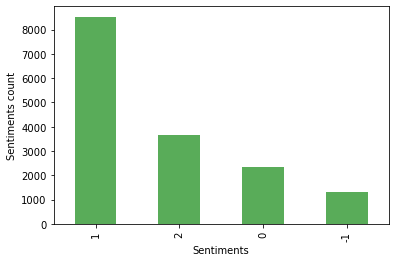

In [13]:
# Bar plot of label classes
fig,ax = plt.subplots()
df_train['sentiment'].value_counts().plot(kind = 'bar', facecolor='g', alpha=0.65)
ax.set_xlabel('Sentiments')
ax.set_ylabel('Sentiments count')
plt.show()

# PUT IN WORD CLOUD BELOW

## Also include findings from world cloud in EDA summary

### EDA summary
- The dataset contains three columns (sentiments, message and tweetid)
- Sentiments and tweetid are of numeric data type, while message is non-numeric
- tweetid is a clumn with uniques values acreoss the entire rows of the dataset
- sentiments columns contains for different unique values (-1, 0, 1 &2) with different sizes

In [14]:
# have a look at feature distributions

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are required to: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

## Text Cleaning

### Removing Noise

For the given dataset, we identified that the *message* column contains the novel tweet for each userid, which we are espected to classify. 
For us to proceed we have to carry out cleaning on this messages. This cleaning will be achieved through:
* identify and remove web-urls from the main message 
* idendify and remove words started with '#'
* idendify and remove words started with '@'
* making everything lower case
* removing punctuation



#### Remove web-url from message

We write a function called *delete_url*. This function uses regex to identify web-url in a column and remove same from the column.

In [15]:
def delete_url(data, col):
    """
        Accepts a dataframe and col., removes web urls from the col.
        returns a new dataframe 
    """
    df = data.copy()
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    subs_url = ''
    df[col] = df[col].replace(to_replace = pattern_url, value = subs_url, regex = True)
    return df

In [16]:
# Create a new dataframe with message colun void of url links
new_df_train = delete_url(df_train, 'message')
new_df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [17]:
# Confirm that the above operation was successful 
new_df_train['message'][0]

"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!?  via @mashable"

In [18]:
df_train['message'][0]

"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable"

### Remove '#' and '@' words

We write a function *delete_tags*, to identify and remove words started with '#' and '@'

In [19]:
def delete_tags(data, col):
    """
        This function takes in a dataframe and a col, removes all words started with '#' and '@' in the column,
        and returns a new dataframe
    """
    df = data.copy()
    pattern_tags = r'#\w+[#?]'
    pattern_2 = r'@\w+'
    subs_tag = ''
    df[col] = df[col].replace(to_replace = pattern_tags, value = subs_tag, regex = True)
    df[col] = df[col].replace(to_replace = pattern_2, value = subs_tag, regex = True)
    return df

In [20]:
# Create a new dataframe with message colun void of url links
new_df_train = delete_tags(new_df_train, 'message')
new_df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT : Researchers say we have three years to ac...,698562
3,1,WIRED : 2016 was a pivotal year in the war on...,573736
4,1,"RT : It's 2016, and a racist, sexist, climate ...",466954


### Convert capitalized words to lowercase words

We write a function *word_converter* to convert capitalized words to lowercase words

In [21]:
def word_converter(data, col):
    """
        This function takes in a dataframe and col, converts all capitalized words in the column to lowercase,
        and returns a new dataframe.
    """
    df = data.copy()
    df[col] = df[col].str.lower()
    return df

In [22]:
# Create a new dataframe with all words in the message column converted to its lowercase form
new_df_train = word_converter(new_df_train, 'message')
new_df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn't think carbon di...,625221
1,1,it's not like we lack evidence of anthropogeni...,126103
2,2,rt : researchers say we have three years to ac...,698562
3,1,wired : 2016 was a pivotal year in the war on...,573736
4,1,"rt : it's 2016, and a racist, sexist, climate ...",466954


### Remove punctuation

We write a function *remove_punc* that uses the string package from python to remove punctions.

In [23]:
def remove_punc(data, col):
    """
        This function takes in a dataframe and a column, uses python string package to identify and remove all
        punctions in the column. It returns a new dataframe
    """
    def operation(post):
        return ''.join([l for l in post if l not in string.punctuation])
    
    df = data.copy()
    
    df[col] = df[col].apply(operation)
    return df

In [24]:
# Create a new dataframe with the message colmn void of punctuations
new_df_train = remove_punc(new_df_train, 'message')
new_df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,rt researchers say we have three years to act...,698562
3,1,wired 2016 was a pivotal year in the war on ...,573736
4,1,rt its 2016 and a racist sexist climate chang...,466954


### Remove new lines (\n)  and 'rt' from the start of any words

We noticed that some words start with '\n' and this is a short form for new line in programming, words started with \n looses its original meaning.

Hence we write a function remove_new_line to execute this task.

In [25]:

def remove_new_line(data, col):
    """
        Takes in a dataframe and a column, returns a new dataframe with a new column void of new line command
    """

    def operation(text):
        result = re.sub("\n", "", text)
        result = re.sub("rt", "", result)
        return result

    df = data.copy()
    
    df[col] = df[col].apply(operation)

    return df

In [26]:
# Create a new dataframe with the message colmn void of punctuations
new_df_train = remove_new_line(new_df_train, 'message')
new_df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,researchers say we have three years to act o...,698562
3,1,wired 2016 was a pivotal year in the war on ...,573736
4,1,its 2016 and a racist sexist climate change ...,466954


### Tokenisation

We write a function *tokenizer* to tokenize the words in the message column and store same in a new column named *message_tok*

In [27]:
def tokenizer(data, col):
    """
        This function takes in a dataframe and a col, creates a new column to store the tokenized words
        in the inputed column, and returns a new dataframe.
    """
    df = data.copy()
    tokeniser = TreebankWordTokenizer()
    df['message_tok'] = df[col].apply(tokeniser.tokenize)
    return df

In [28]:
# Create a new column to hold the tokens from message column
new_df_train = tokenizer(new_df_train, 'message')
new_df_train.head()

,sentiment,message,tweetid,message_tok
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,researchers say we have three years to act o...,698562,"[researchers, say, we, have, three, years, to,..."
3,1,wired 2016 was a pivotal year in the war on ...,573736,"[wired, 2016, was, a, pivotal, year, in, the, ..."
4,1,its 2016 and a racist sexist climate change ...,466954,"[its, 2016, and, a, racist, sexist, climate, c..."


### Stemming

We write a function *stem_words* to transform all words in the *message_tok* column to its root form.

In [29]:
def stem_words(data, col):
    """
        Takes in a dataframe and a column, converts the words in the column to it root form,
        with the aid of SnowballStemmer class from the nltk package.
        Returns a new dataframe with an additional column "message_stem"
    """
    stemmer = SnowballStemmer('english')
    def operation(words, stemmer):
        return [stemmer.stem(word) for word in words]
    
    df = data.copy()
    df["message_stem"] = df[col].apply(operation, args=(stemmer, ))
    
    return df

In [30]:
# Create a new column to hold root words from stemmer
new_df_train = stem_words(new_df_train, 'message_tok')
new_df_train.head()

,sentiment,message,tweetid,message_tok,message_stem
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evid, of, anthropoge..."
2,2,researchers say we have three years to act o...,698562,"[researchers, say, we, have, three, years, to,...","[research, say, we, have, three, year, to, act..."
3,1,wired 2016 was a pivotal year in the war on ...,573736,"[wired, 2016, was, a, pivotal, year, in, the, ...","[wire, 2016, was, a, pivot, year, in, the, war..."
4,1,its 2016 and a racist sexist climate change ...,466954,"[its, 2016, and, a, racist, sexist, climate, c...","[it, 2016, and, a, racist, sexist, climat, cha..."


### Larmming

We write a function *lam_words* to transform all words in the *message_tok* column to its root form using Lemmatization, to enable us acrter for the shortfall in stemming above.

In [31]:
def lam_words(data, col):
    """
        Takes in a dataframe and a column, converts the words in the column to it root form,
        with the aid of WordNetLemmatizer class from the nltk package.
        Returns a new dataframe with an additional column "message_lam"
    """
    lemmatizer = WordNetLemmatizer()
    def operation(words, lemmatizer):
        return [lemmatizer.lemmatize(word) for word in words] 
    df = data.copy()
    df["message_lam"] = df[col].apply(operation, args=(lemmatizer, ))
    
    return df

In [32]:
# Create a new column to hold root words from stemmer
new_df_train = lam_words(new_df_train, 'message_tok')
new_df_train.head()

,sentiment,message,tweetid,message_tok,message_stem,message_lam
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evid, of, anthropoge...","[it, not, like, we, lack, evidence, of, anthro..."
2,2,researchers say we have three years to act o...,698562,"[researchers, say, we, have, three, years, to,...","[research, say, we, have, three, year, to, act...","[researcher, say, we, have, three, year, to, a..."
3,1,wired 2016 was a pivotal year in the war on ...,573736,"[wired, 2016, was, a, pivotal, year, in, the, ...","[wire, 2016, was, a, pivot, year, in, the, war...","[wired, 2016, wa, a, pivotal, year, in, the, w..."
4,1,its 2016 and a racist sexist climate change ...,466954,"[its, 2016, and, a, racist, sexist, climate, c...","[it, 2016, and, a, racist, sexist, climat, cha...","[it, 2016, and, a, racist, sexist, climate, ch..."


### Remove stop words
Stop words are words which do not contain important significance to be used in Search Queries. 
We write a function *remove_stop_word*, that removes stop words in a speified column.

In [33]:
def remove_stop_words(data, col):
    """
        Takes a dataframe and a column, creates a new dataframe with a new column no_stop_word from the input
        dataframe and column, returns the new column
    """
    def operation(toks):
        new_toks = [tok for tok in toks if tok not in stopwords.words('english')]
        return new_toks
    
    df = data.copy()
    df['no_stop_word'] = df[col].apply(operation)

    return df

In [ ]:
# Create a new column from message_lam void of stop words
new_df_train = remove_stop_words(new_df_train, 'message_lam')
new_df_train.head()

### Check for the presence of noise as non-alphanumeric worlds

In [ ]:
def word_type_checker(data, col):
    alphanum_count = 0 
    non_alphanum_count = 0
    
    def operation(str_list , alphanum_count ,non_alphanum_count):
        alphanum = alphanum_count
        non_aphanum = non_alphanum_count
#         print(f'past row values: {(alphanum, non_aphanum)}') # for testing 
        for strg in str_list:
            if strg.isalnum():
                alphanum = alphanum + 1
            else:
                non_aphanum = non_aphanum + 1
        
        return (alphanum ,non_aphanum)
    
    for label, sr in data.iterrows():
        (alphanum_count, non_alphanum_count) = operation(sr[col] , alphanum_count, non_alphanum_count)
#         Uncomment the codes below for testing of this function
#         print(f'accumulated values: {(alphanum_count, non_alphanum_count)}') 
#         if label == 20:
#             break
    
    return (alphanum_count, non_alphanum_count)
            
    

In [ ]:
(alphanumeric, non_alphanumeric) = word_type_checker(new_df_train, 'no_stop_word')
(alphanumeric, non_alphanumeric)

### Transforming text into numbers

- CounterVectorizer
- TfidfVectorizer

Most models do not work well with text, hence the need to convert our text into numbers. To execute this task and more, we can use **CountVectorizer** or **TfidfVectorizer** packages from sklearn library.

#### CountVectorizer
**CountVectorizer** has some **hyperparameters** which we can asign desired values to while initialising. 
The **hyperparameters** that we shall be tunning for these work are: 

- **max_df** :  When building the vocabulary ignore terms that have a document frequency strictly higher than the                     given threshold (corpus-specific stop words). If float, the parameter represents a proportion of                       documents,integer absolute counts.This parameter is ignored if vocabulary is not None.

- **min_df** :  When building the vocabulary ignore terms that have a document frequency strictly lower than the given                 threshold. This value is also called cut-off in the literature. If float, the parameter represents a                   proportion of documents, integer absolute counts.This parameter is ignored if vocabulary is not None.

- **max_features**: If not None, build a vocabulary that only consider the top max_features ordered by term frequency                     across the corpus. This parameter is ignored if vocabulary is not None.

- **analyzer**: Whether the feature should be made of word n-gram or character n-grams. Option ‘char_wb’ creates                       character n-grams only from text inside word boundaries; n-grams at the edges of words are padded with                 space.

- **ngram_range**: The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to                    be extracted.

In [ ]:
vect_df = CountVectorizer(max_features=20000,analyzer='word', ngram_range=(1, 2))
vect_downsampled = CountVectorizer(max_features=20000,analyzer='word', ngram_range=(1, 2))
vect_upsampled = CountVectorizer(max_features=20000,analyzer='word', ngram_range=(1, 2))

#### TfidfVectorizer

### Convert processed words to corpus

Before we can transform the words in numeric type, for each column we have to remove the delimeters introduced during tokennization. This process is needed to enable us form a **corpus**.
To achieve this, we write a function **form_corpus**.

In [ ]:
def form_corpus(data, col):
    """
        This function takes in a dataframe and a column with tokenized text, 
        returns a new dataframe with an additional column(de_tok), which is made up of all words in the inserted colunm
        but void of delimeters.
    """
    def operation(tok_list):
        string = ' '.join(tok_list)
        return string
    df = data.copy()
    df['de_tok'] = df[col].apply(operation)
    
    return df

In [ ]:
# Create a new column from no_stop_word void of delimeters
new_df_train = form_corpus(new_df_train, 'no_stop_word')
new_df_train.head()

In [ ]:
# Drop every other columns except sentiment and de_tok columns
df_train_reduced = new_df_train[['sentiment', 'de_tok']]
df_train_reduced.head()

### Resampling
- **Downsampling the majority class**
- **Upsampling the minority class**

To achieve the above, we write a multipurpose function called **resampler**, which we can use for both **Downsampling** and **Upsampling**

In [ ]:
def resampler(df_list, n_sample, replace=False):
    """
        This function takes a list of dataframe, the size which we intend to resize all dataframes in the list to, and
        an optional replace[bool] value, which is set to True for upsampling
        It returns a tuple of new dataframes with sizes equivalent to the value for n_sample
    """
    
    def operation(df):
        downsampled_df = resample(df,
                          replace= replace, # sample without replacement (no need to duplicate observations)
                          n_samples=n_sample, # match number in minority class
                          random_state= RANDOM_STATE) # reproducible results
        return downsampled_df
    
    resampled_dfs = tuple(map(operation , df_list))
    
    return resampled_dfs

#### Create new dataframes
    We create new dataframes basedd on sentiment type.

In [ ]:
pro = df_train_reduced[df_train_reduced['sentiment'] == 1]
anti = df_train_reduced[df_train_reduced['sentiment'] == -1]
neutral = df_train_reduced[df_train_reduced['sentiment'] == 0]
info =  df_train_reduced[df_train_reduced['sentiment'] == 2]

### Downsampling
    
    

In [ ]:
# Downsample pro, infor and neutral dataframe 
(pro_df, info_df, neut_df) = resampler([pro,info,neutral], len(anti))

# Combine downsampled majority class with minority class
downsampled = pd.concat([pro_df, info_df, neut_df,anti])

# Check new class counts
downsampled['sentiment'].value_counts()

In [ ]:
# visualise the downsampled dataframe
original_height = [len(pro), len(neutral), len(info), len(anti)]
downsampled_heights = [len(downsampled[downsampled['sentiment']==1]),len(downsampled[downsampled['sentiment']==0]),
                      len(downsampled[downsampled['sentiment']==2]) ,len(downsampled[downsampled['sentiment']==-1])]

# Get all possible labels
labels = downsampled['sentiment'].unique()
plt.bar(labels,original_height,color='grey')
plt.bar(labels,downsampled_heights,color='orange')
plt.xticks(labels,[1,0, 2, -1])
plt.ylabel("# of observations")
plt.xlabel("Sentiments")
plt.legend(['original','resampled'])
plt.show()

### Upsampling

In [ ]:
# upsample info, neutral and anti dataframe 
(up_info_df, up_neut_df, up_anti_df) = resampler([info,neutral, anti], len(pro), True)

# Combine downsampled majority class with minority class
upsampled = pd.concat([pro, up_info_df, up_neut_df,up_anti_df])

# Check new class counts
upsampled['sentiment'].value_counts()

In [ ]:
# visualise the upnsampled dataframe
original_height = [len(pro), len(neutral), len(info), len(anti)]
upsampled_heights = [len(upsampled[upsampled['sentiment']==1]),len(upsampled[upsampled['sentiment']==0]),
                      len(upsampled[upsampled['sentiment']==2]) ,len(upsampled[upsampled['sentiment']==-1])]

# Get all possible labels
labels = upsampled['sentiment'].unique()
plt.bar(labels,upsampled_heights,color='orange')
plt.bar(labels,original_height,color='grey')
plt.xticks(labels,[1,0, 2, -1])
plt.ylabel("# of observations")
plt.xlabel("Sentiments")
plt.legend(['original','resampled'])
plt.show()

#### Data Transformation 

We use the instance of **CountVectorizer** **(vect_20)** created above to fit and transform all samples of dataframes

#### Data transformation for original data size

In [ ]:
# Transform the de_tok column
X_count = vect_df.fit_transform(df_train_reduced['de_tok'].values.astype(str))
X_count.shape

#### Data transformation for Downsampled data

In [ ]:
X_count_downsampled = vect_downsampled.fit_transform(downsampled['de_tok'].values.astype(str))
X_count_downsampled.shape

#### Data transformation for Upsampled data

In [ ]:
X_count_upsampled = vect_upsampled.fit_transform(upsampled['de_tok'].values.astype(str))
X_count_upsampled.shape

#### Separate features and dependant for all three dataset

#### Features and dependant for original dataset

In [ ]:
# Collect the dependant variable into a variable
y = df_train_reduced['sentiment']
y[:10]

In [ ]:
# See feature names
# vect_df.get_feature_names()

In [ ]:
X_count.toarray()

#### Features and dataset for downsampled dataset

In [ ]:
# Collect the dependant downsampled dataset
y_downsampled = downsampled['sentiment']
y_downsampled[:10]

In [ ]:
X_count_downsampled.toarray()

In [ ]:
# See feature names
# vect_downsampled.get_feature_names()

#### Features and dataset for upsampled dataset

In [ ]:
# Collect the dependant downsampled dataset
y_upsampled = upsampled['sentiment']
y_upsampled[:10]

In [ ]:
X_count_upsampled.toarray()

In [ ]:
# See feature names
# vect_upsampled.get_feature_names()

### Convert all processed dataset back to dataframe form

### Original dataset

In [ ]:
model_df = pd.DataFrame(data=X_count.toarray(),columns = vect_df.get_feature_names())
model_df.head()

### Downsampled dataset

In [ ]:
downsampled_df = pd.DataFrame(data=X_count_downsampled.toarray(),columns = vect_downsampled.get_feature_names())
downsampled_df.head()

### upsampled dataset

In [ ]:
upsampled_df = pd.DataFrame(data=X_count_upsampled.toarray(),columns = vect_upsampled.get_feature_names())
upsampled_df.head()

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, you are required to create one or more regression models that are able to accurately predict the thee hour load shortfall. |

---

### Logistics Regression

We proceed to create a **Logistics Regression model** for the three types of dataset we have:
- original dataset
- downsampled dataset
- upsampled dataset

#### Instanciate Logistic Regression Model

In [ ]:
# create one or more ML models
# logreg = LogisticRegression(multi_class='ovr')
# logreg_down = LogisticRegression(multi_class='ovr')
# logreg_up = LogisticRegression(multi_class='ovr')

#### RandomForest Classification Model

In [ ]:

logreg = RandomForestClassifier(n_estimators=100, random_state=42)
logreg_down = RandomForestClassifier(n_estimators=100, random_state=42)
logreg_up = RandomForestClassifier(n_estimators=100, random_state=42)

### Train the model with the original dataset

We fit the model with the features(**model_df**) and the dependant (**y**)

In [ ]:
#Fit the model generated above
log_fit = logreg.fit(model_df, y)

### Train the model with the downsampled dataset

We fit the model with the features(**downsampled_df**) and the dependant (**y_downsampled**)

In [ ]:
#Fit the model generated above
downsampled_fit = logreg_down.fit(downsampled_df, y_downsampled)

### Train the model with the upsampled dataset

We fit the model with the features(**upsampled_df**) and the dependant (**y_upsampled**)

In [ ]:
#Fit the model generated above
upsampled_fit = logreg_up.fit(upsampled_df, y_upsampled)

#### Prediction

To enable us make prediction with our model, we have to import the **test** dataset and execute all data engineering operation executed on the **train** dataset.

These activities are: 
- **delete urls**
- **delete tags**
- **convert words to lowercases**
- **remove punctions**
- **remove newlines**
- **tokenize**
- **stemming**
- **larmming**
- **remove stop words**

In [ ]:
# Import and view the first 5 rolls of our training dataset
df_test = pd.read_csv('data/test.csv')
df_test.head()

In [ ]:
# Create a new dataframe with message colun void of url links
new_df_test = delete_url(df_test, 'message')
new_df_test.head()

In [ ]:
# Create a new dataframe with message colun void of url links
new_df_test = delete_tags(new_df_test, 'message')
new_df_test.head()

In [ ]:
# Create a new dataframe with all words in the message column converted to its lowercase form
new_df_test = word_converter(new_df_test, 'message')
new_df_test.head()

In [ ]:
# Create a new dataframe with the message colmn void of punctuations
new_df_test = remove_punc(new_df_test, 'message')
new_df_test.head()

In [ ]:
# Create a new dataframe with the message colmn void of punctuations
new_df_test = remove_new_line(new_df_test, 'message')
new_df_test.head()

In [ ]:
# Create a new column to hold the tokens from message column
new_df_test = tokenizer(new_df_test, 'message')
new_df_test.head()

In [ ]:
# Create a new column to hold root words from stemmer
new_df_test = stem_words(new_df_test, 'message_tok')
new_df_test.head()

In [ ]:
# Create a new column to hold root words from stemmer
new_df_test = lam_words(new_df_test, 'message_tok')
new_df_test.head()

In [ ]:
# Create a new column from message_lam void of stop words
new_df_test = remove_stop_words(new_df_test, 'message_lam')
new_df_test.head()

In [ ]:
# Create a new column from no_stop_word void of delimeters
new_df_test = form_corpus(new_df_test, 'no_stop_word')
new_df_test.head()

In [ ]:
# Drop every other columns except sentiment and de_tok columns
df_test_reduced = new_df_test[[ 'de_tok']]
df_test_reduced.head()

### Transform test dataset 

We transform the test dataset using the three different obects of the text transfromer generated above:
- **vect_df** : for original dataset
- **vect_downsampled** : for downsampled dataset
- **vect_upsampled** : for upsampled dataset

#### Original dataset

In [ ]:
# Transform the de_tok column
X_count_test = vect_df.transform(df_test_reduced['de_tok'].values.astype(str))
X_count_test.shape

In [ ]:
text_df = pd.DataFrame(data=X_count_test.toarray(),columns = vect_df.get_feature_names())
text_df.head()

#### Downsampled dataset

In [ ]:
# Transform the de_tok column
X_count_test_downsampled = vect_downsampled.transform(df_test_reduced['de_tok'].values.astype(str))
X_count_test_downsampled.shape

In [ ]:
text_downsampled = pd.DataFrame(data=X_count_test_downsampled.toarray(),columns = vect_downsampled.get_feature_names())
text_downsampled.head()

#### Upsampled dataset

In [ ]:
# Transform the de_tok column
X_count_test_upsampled = vect_upsampled.transform(df_test_reduced['de_tok'].values.astype(str))
X_count_test_upsampled.shape

In [ ]:
text_upsampled = pd.DataFrame(data=X_count_test_upsampled.toarray(),columns = vect_upsampled.get_feature_names())
text_upsampled.head()

### Make predictions with the models generated above and listed below:
- **logreg** (original dataset)
- **downsampled_fit** (downsampled dataset)
- **upsampled_fit** (upsampled dataset)


#### logreg (original dataset)

In [ ]:
# Make prediction with model from original dataset
y_pred_test = logreg.predict(text_df)

## Personally, I feel we need to confirm the need for code below

We need to confirm this.

In [ ]:
# Import and view the first 5 rolls of our training dataset
# df_sample = pd.read_csv('data/sample_submission.csv')
# y_exact = df_sample['sentiment']
# df_sample.tail()

#### downsampled_fit (downsampled dataset)

In [ ]:
# Make prediction with model from downsampled dataset
y_pred_downsampled = downsampled_fit.predict(text_downsampled)

#### upsampled_fit (upsampled dataset)

In [ ]:
# Make prediction with model from upsampled dataset
y_pred_upsampled = upsampled_fit.predict(text_upsampled)

In [ ]:
# df_test.tail()


<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [ ]:
# # Classification report
# from sklearn.metrics import classification_report
# print(classification_report(y_exact, y_pred_test, labels= [1,2,0,-1]))

### Convert the predictions to dataframe

We have generated predictions three different predictions using three different models as stated below :
- **model** : logreg , **prediction** : y_pred_test
- **model** : downsampled_fit , **prediction** : y_pred_downsampled
- **model** : upsampled_fit , **prediction** : y_pred_upsampled


#### model : logreg , prediction : y_pred_test

In [ ]:
# Choose best model and motivate why it is the best choice

df = pd.DataFrame({
    'tweetid': df_test['tweetid'],
    'sentiment': y_pred_test
})

df.head()

In [ ]:
df.to_csv('file_001.csv',index=False)

#### model : downsampled_fit , prediction : y_pred_downsampled

In [ ]:
downsampled_df = pd.DataFrame({
    'tweetid': df_test['tweetid'],
    'sentiment': y_pred_downsampled
})

downsampled_df.head()

In [ ]:
downsampled_df.to_csv('file_002.csv',index=False)

#### model : upsampled_fit , prediction : y_pred_upsampled

In [ ]:
upsampled_df = pd.DataFrame({
    'tweetid': df_test['tweetid'],
    'sentiment': y_pred_upsampled
})

upsampled_df.head()

In [ ]:
upsampled_df.to_csv('file_003.csv',index=False)

### Logging Results to Comet

#### Model Performance Metrics

In [ ]:
# Generate all metrics for model performance
# f1 = f1_score(y_true, y_pred_test, average = 'weighted')
# precision = precision_score(y_true, y_pred_test, average ='weighted')
# recall = recall_score(y_true, y_pred_test,average = 'weighted')
# accuracy = accuracy_score(y_true, y_pred_test)

### Create disctionary for data to be stored on Comet_ml

In [ ]:
# Generates two dictionaries, parameters and metric values
# params = {
#     'random_state': RANDOM_STATE,
#     'model_type': 'Logistics Regression'
# }

# metrics ={
#     'Accuracy': accuracy,
#     'precision': precision,
#     'recall': recall,
#     'f1': f1,
# }
# metrics

### Log parameters and metrics to commet_ml

In order to adher to a fundamental pricinple of programming **DRY**(do not repeat yourself), we define a function **experiment_logger** to achieve this. This is because this is a group project with multiple comet_ml API keys. 

In [ ]:
def experiment_logger(experiments):
    """
        This function takes in a list of comet_ml defined experiments, and logs the parameters and metric values,
        for this notebook to the respective experiments. It has a return value of None
    """
    for experiment in experiments :
        experiment.log_parameters(params)
        experiment.log_metrics(metrics)
    return None
        

In [ ]:
# # Create a list of comet experiments for this project
# comet_experiments = [ experiment]

# # Log the respective experiments parameter and metric values
# experiment_logger(comet_experiments)

### End all comet experiment after loging the parameters

To adhre to the **DRY** principle, we write a function **end_comet** to achieve this


In [ ]:
def end_comet(experiments):
    """
        This function takes in a list of comet_ml defined experiments, and ends the experiments.
        It has a return value of None.
    """
    for experiment in experiments :
        experiment.end()
        
    return None

In [ ]:
# # End all experiments
# end_comet(comet_experiments)

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
| In this section, you are required to discuss how the best performing model works in a simple way so that both technical and non-technical stakeholders can grasp the intuition behind the model's inner workings. |

---